### JULIA IS FAST

Very often, benchmarks are often used to compare languages. These benchmarkscan lead to long discussions, first as to exactly what is being benchmarked and secondly what is being benchmarked and secondly what explains the differences. These simple questions can sometimes get more complicated than you at first might imagine.

SUM: An easy enough function to understand

consider the sum function sum(a), which computes
        sum(a) = $\sum_{i=1}^{n}a_i$

where, n is length of a.

In [1]:
a = rand(10^7) # 1D vextor of random numbers, uniform on (0,1)

10000000-element Vector{Float64}:
 0.8554417468421789
 0.8880003454147799
 0.17558092232570233
 0.9102601824145701
 0.6182066328787673
 0.3998001842773963
 0.5093841728119243
 0.6637641831991989
 0.9211524461161279
 0.01631649762340126
 ⋮
 0.2372419450449026
 0.18687801990387887
 0.3293821421895101
 0.7376706276438979
 0.5865520094175405
 0.3305806428994992
 0.7781783452120922
 0.6060717932425294
 0.5825952072234444

In [2]:
@time sum(a)

  0.069994 seconds (57.83 k allocations: 2.920 MiB, 90.15% compilation time)


4.998950146195335e6

The expected result is 0.5 *(10^7). Since, the mean of each entry is 0.5

The @time macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a BenchmarkTools.jl package to make benchmarking easy and accurate:

### Use BenchmarkTools for comparison

In [3]:
# import Pkg; Pkg.add("BenchmarkTools")

In [4]:
using BenchmarkTools

### 1. The C language

C is often considered the golden standerd: difficult on the human, nice for the machine.
Getting within  a factor of 2 of C is often satisfying. Nontheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read her cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the """ warp a multiline string.

In [5]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [6]:
c_sum(a)

4.998950146195717e6

In [7]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbol

true

In [8]:
c_sum(a) - sum(a)

3.818422555923462e-7

In [9]:
≈       # alias for the 'isapprox' function

isapprox (generic function with 13 methods)

In [10]:
# @doc isapprox

We can now bench mark the C code directly from Julia

In [11]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 253 samples with 1 evaluation per sample.
 Range (min … max):  12.235 ms … 65.568 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     18.152 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   19.535 ms ±  5.447 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

        ▁▄▄█▃▁                                                 
  ▂▁▂▂▅▃███████▅▇▆▄▄▄▃▅▃▄▂▁▂▃▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▃
  12.2 ms         Histogram: frequency by time          46 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [12]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 12.2352 msec


In [13]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 12.2352

In [14]:
using Plots
gr()

Plots.GRBackend()

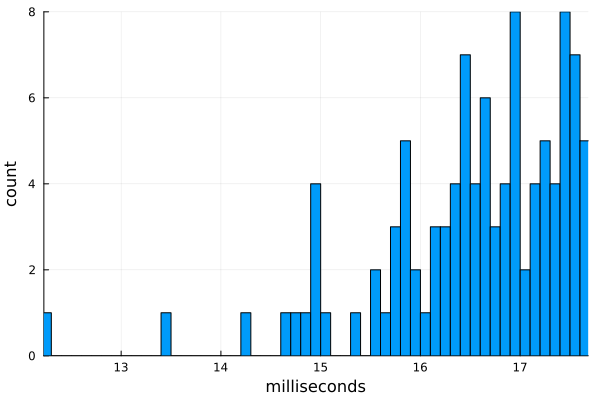

In [15]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

### 2. C with -ffast-math
If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD 
(single instruction, multiple data) instructions.

In [16]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [17]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 506 samples with 1 evaluation per sample.
 Range (min … max):  6.222 ms … 61.661 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.895 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.862 ms ±  4.375 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▇▅▅▃▆▄▁  ▁▁                                                
  █████████████▅██▇▇▇▅▆▄▄▇▅▅▃▃▄▃▃▂▃▂▃▃▁▁▂▂▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▂▂ ▄
  6.22 ms        Histogram: frequency by time        23.6 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [18]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 2 entries:
  "C"             => 12.2352
  "C -ffast-math" => 6.2217

### 3. Python's built in sum

The PyCall package provides a Julia interface to Python:

In [19]:
# import Pkg; Pkg.add("PyCall")

In [20]:
using PyCall

In [21]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [22]:
pysum(a) ≈ sum(a)

true

In [23]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 6 samples with 1 evaluation per sample.
 Range (min … max):  811.644 ms …    1.169 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     892.960 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   928.160 ms ± 123.224 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █           ███  █                                          █  
  █▁▁▁▁▁▁▁▁▁▁▁███▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  812 ms           Histogram: frequency by time          1.17 s <

 Memory estimate: 208 bytes, allocs estimate: 8.

In [24]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 12.2352
  "Python built-in" => 811.644
  "C -ffast-math"   => 6.2217

### 4. Python: numpy
Takes advantage of hardware "SIMD", but only works when it works.

**numpy** is an optimized C library, callable from Python. It may be installed within Julia as follows:

In [25]:
# import Pkg; Pkg.add("Conda")
using Conda     

In [26]:
numpy_sum = pyimport("numpy")["sum"]
a̅ = PyObject(a)         # converts into a numpy array by Default

py_numpy_bench = @benchmark $numpy_sum($a̅)

BenchmarkTools.Trial: 549 samples with 1 evaluation per sample.
 Range (min … max):  7.123 ms … 18.604 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.604 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.095 ms ±  2.108 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▄▃▂▃▂▁▂▃▄▁ ▁ ▁▃▄▃▃▁▂▁                                      
  ███████████████████████▇▇▇▅▅▆▆▆▄▄▄▄▇▁▄▁▁▄▄▄▄▁▆▄▆▄▄▁▄▁▁▆▄▁▆ ▇
  7.12 ms      Histogram: log(frequency) by time     16.9 ms <

 Memory estimate: 32 bytes, allocs estimate: 2.

In [27]:
numpy_sum(a̅)

4.998950146195335e6

In [28]:
numpy_sum(a̅) ≈ sum(a)

true

In [29]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 12.2352
  "Python numpy"    => 7.1232
  "Python built-in" => 811.644
  "C -ffast-math"   => 6.2217

### 5. Python, hand-written

In [30]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x000001B547079300>

In [31]:
py_hand = @benchmark $sum_py($a̅)

BenchmarkTools.Trial: 6 samples with 1 evaluation per sample.
 Range (min … max):  937.565 ms … 980.802 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     955.691 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   956.055 ms ±  14.621 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █           █           █ █     █                           █  
  █▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  938 ms           Histogram: frequency by time          981 ms <

 Memory estimate: 32 bytes, allocs estimate: 2.

In [32]:
sum_py(a̅)

4.998950146195717e6

In [33]:
sum_py(a̅) ≈ sum(a)

true

In [34]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 12.2352
  "Python numpy"        => 7.1232
  "Python hand-written" => 937.565
  "Python built-in"     => 811.644
  "C -ffast-math"       => 6.2217